# Neural networks - Homework (basic)

In [ ]:
#!pip install pymorphy2
#!pip install -U pymorphy2-dicts-ru
#!pip install pymystem3
#!pip install gensim

In [1]:
import gc
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

import keras
from keras.callbacks import Callback, History
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils, to_categorical

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from IPython.display import display

warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

Using TensorFlow backend.


TensorFlow version: 1.13.1
Keras version: 2.2.4


In [237]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Flatten
from keras.datasets import imdb

from sklearn.preprocessing import LabelEncoder

import string
import pymorphy2
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

# Writing utility code

In [126]:
from matplotlib.ticker import MaxNLocator

class TrainingHistory(keras.callbacks.Callback):
    """
    Class to accumulate and plot metrics.
    Can be used separately or as a Keras callback.
    """
    def __init__(self, metric='acc', metric_name='Accuracy', report_num_epochs=10):
        super().__init__()
        self.metric = metric
        self.metric_name = metric_name
        self.train_loss_list = []
        self.train_metric_list = []
        self.test_loss_list = []
        self.test_metric_list = []
        self.report_num_epochs = report_num_epochs

    def on_epoch_end(self, batch, logs={}):
        self.train_loss_list.append(logs.get('loss'))
        self.test_loss_list.append(logs.get('val_loss'))
        self.train_metric_list.append(logs.get(self.metric))
        self.test_metric_list.append(logs.get('val_%s' % self.metric))
        
        epoch_num = len(self.train_loss_list)
        if epoch_num % self.report_num_epochs == 0:
            print('Epoch {0}: loss={1} {2}={3:.4f}'.format(epoch_num, self.train_loss_list[-1],
                                                           self.metric, self.train_metric_list[-1]))
    
    def print_scores(self):
        
        print('{0}: train={1:.4f}, test={2:.4f}'.format(self.metric_name,
                                                        self.train_metric_list[-1],
                                                        self.test_metric_list[-1]))
        print('Loss: train={0:.4f}, test={1:.4f}'.format(self.train_loss_list[-1],
                                                         self.test_loss_list[-1]))
            
    def plot(self):
        f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        plt.subplots_adjust(wspace=0.2, hspace=0.2)

        axes[0].set_title('Loss', fontsize=16, fontweight='bold')
        axes[1].set_title(self.metric_name, fontsize=16, fontweight='bold')

        axes[0].plot(self.train_loss_list, label='Train set')
        axes[0].plot(self.test_loss_list, label='Test set')

        axes[1].plot(self.train_metric_list, label='Train set')
        axes[1].plot(self.test_metric_list, label='Test set')

        axes[0].set_xlabel("Epoch")
        axes[1].set_xlabel("Epoch")

        # Only integer epoch labels
        axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
        axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

        axes[0].legend()
        axes[1].legend()

In [157]:
def show_class_histogram(df, col='Class'):
    total = float(len(df))
    ax = sns.countplot(x=col, data=df)

    for p in ax.patches:
        height = p.get_height() # bar integer value (not pixels here!)
        height = 0 if np.isnan(height) else height
        ax.text(
            p.get_x() + p.get_width()/2, height, 
            '{0} ({1:1.2f}%)'.format(height, height * 100/total), ha="center"
        )
    ax.set_title('Distribution of target class', fontsize=14, fontweight='bold')
    plt.show()

# Loading data and text processing

In [231]:
DATA_PATH = 'D://datasets//feedback//feedback.csv'
PROCESSED_PATH = 'D://datasets//feedback//feedback-processed.csv'

In [37]:
def load_data():
    ratings = []
    texts = []

    with open(DATA_PATH, 'r', encoding='utf-8') as f:
        next(f)    # skip header line
        for line in f.readlines():
            splitted = line.split(',')
            rating = int(float(splitted[0]))
            text = ','.join(splitted[4:]).strip('"')
            ratings.append(rating)
            texts.append(text)
            
    return pd.DataFrame({'text': texts, 'rating': ratings})        

In [38]:
df = load_data()

In [226]:
stop_chars = str.maketrans({key: ' ' for key in string.punctuation})
stop_words = stopwords.words('russian')
tokenizer = RegexpTokenizer(r"(?u)\b[^\W\d][^\W\d]+\b")
morph = pymorphy2.MorphAnalyzer()
mystem = Mystem()
mapping = False

def preprocessor(text):
    return text.lower()


def lemmed_words_pymorphy(doc):
    """ Split to tokens, ignore stopwords, apply lemmatization. """
    return [
        morph.parse(word)[0].normal_form
        for word in tokenizer.tokenize(doc)
        if len(word) > 1 and word not in stop_words
    ]


def lemmed_words_mystem(doc):
    
    doc = ' '.join([
        word
        for word in tokenizer.tokenize(doc)
        if len(word) > 1 and word not in stop_words
    ])
    
    processed = mystem.analyze(doc)
    lemmas = []
    for w in processed:
        try:
            lemma = w["analysis"][0]["lex"].lower().strip()
            pos = w["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
            if mapping:
                if pos in mapping:
                    pos = mapping[pos]   # part of speech tag mapping
                else:
                    pos = 'X'  # if tag is missing from the mapping
            lemmas.append(lemma + '_' + pos)
        except (KeyError, IndexError):
            continue

    return lemmas

Some examples for the lemmer:

In [229]:
print(lemmed_words_mystem('волчий вой'))
print(lemmed_words_mystem('волком вой'))
print(lemmed_words_mystem('холодно'))

['волчий_A', 'вой_S']
['волк_S', 'выть_V']
['холодно_ADV']


Apply lemmatization and point-of-speech tagging (takes a long time) and save intermediate results to disk:

In [230]:
df['words'] = df.text.map(lambda x: lemmed_words_mystem(preprocessor(x)))
df['words_count'] = df['words'].map(len)
df['words_concat'] = df['words'].apply(' '.join)

df.to_csv(PROCESSED_PATH, sep=',', encoding='utf-8')

# EDA and further processing

Read processed data from disk to avoid expensive processing:

In [235]:
#df2 = pd.read_csv(PROCESSED_PATH)

Word count distribution (useful to determine max text length for padding):

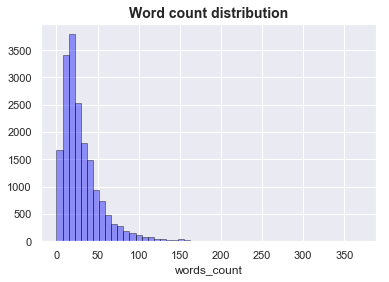

In [249]:
sns.distplot(df['words_count'], hist=True, kde=False, 
             bins=50, color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Word count distribution', fontsize=14, fontweight='bold')
plt.show()

Let's take a look at class balance:

In [261]:
num_classes = df['rating'].nunique()

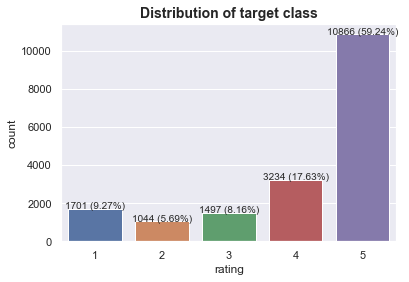

In [251]:
show_class_histogram(df, col='rating')

Pretty bad, let's apply oversampling to compensate:

In [245]:
def oversample(df, col='rating'):
    max_size = df[col].value_counts().max()

    dfs = [df]
    for class_index, group in df.groupby(col):
        dfs.append(group.sample(max_size-len(group), replace=True))
    return pd.concat(dfs)

In [252]:
df = oversample(df)

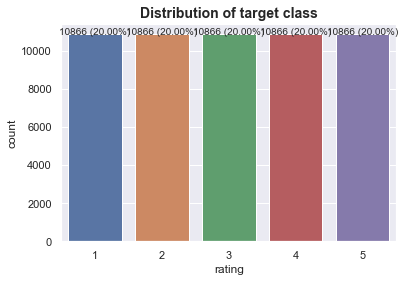

In [254]:
show_class_histogram(df, col='rating')

Much better.

# RNN with randomly initialized embeddings

(based on example provided here: https://github.com/keras-team/keras/blob/master/examples/imdb_bidirectional_lstm.py)

In [ ]:
MAX_LENGTH = 50      # max text length in word, selected according to word count distribution plot
MAX_FEATURES = 300   # embedding dimension, chosen to match dimension of
                     # RusVectores embedding for "fair" comparison
VOCAB_SIZE = 10000

Apply integer encoding and pad sequences:

In [307]:
encoded_docs = [one_hot(d, VOCAB_SIZE) for d in df['words_concat']]
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_LENGTH, padding='post')

Split into train/test set:

In [308]:
target = df['rating']

X_train, X_test, y_train, y_test = train_test_split(
    padded_docs, target,  random_state=42, stratify=target,
)

Apply one-hot encoding to target class:

In [309]:
encoder = LabelEncoder()
encoder.fit(y_train)

y_train_onehot = np_utils.to_categorical(encoder.transform(y_train))
y_test_onehot = np_utils.to_categorical(encoder.transform(y_test))

Training the model:

In [313]:
from keras import backend as K; K.clear_session()
tf.reset_default_graph()

adam = keras.optimizers.Adam()

model = Sequential()
model.add(Embedding(VOCAB_SIZE, MAX_FEATURES, input_length=MAX_LENGTH))
model.add(Bidirectional(LSTM(10)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer=adam)

history = TrainingHistory(metric='categorical_accuracy', metric_name='Accuracy',
                          report_num_epochs=1)

Epoch 1: loss=1.160891230553619 categorical_accuracy=0.5151
Epoch 2: loss=0.6404819536384496 categorical_accuracy=0.7633
Epoch 3: loss=0.42115006712453307 categorical_accuracy=0.8522
Epoch 4: loss=0.2986998910944538 categorical_accuracy=0.8985
Epoch 5: loss=0.23592983446586502 categorical_accuracy=0.9224
Epoch 6: loss=0.18328403990258527 categorical_accuracy=0.9408
Epoch 7: loss=0.14651722680423224 categorical_accuracy=0.9529
Epoch 8: loss=0.1231272842461783 categorical_accuracy=0.9606
Epoch 9: loss=0.109359547246412 categorical_accuracy=0.9654
Epoch 10: loss=0.09363687586815593 categorical_accuracy=0.9691
Accuracy: train=0.9691, test=0.9331
Loss: train=0.0936, test=0.2776


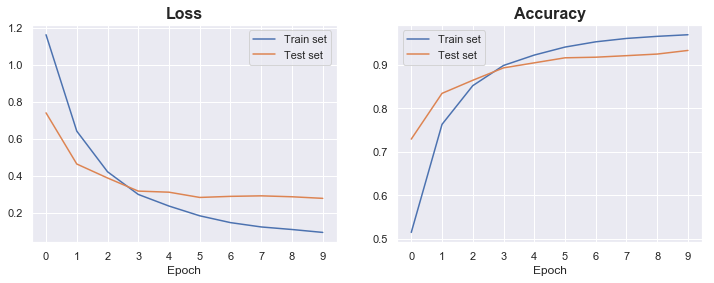

In [314]:
model.fit(
    X_train, y_train_onehot, epochs=len(history.train_loss_list) + 10, batch_size=batch_size, verbose=0,
    validation_data=(X_test, y_test_onehot),
    callbacks=[history], initial_epoch=len(history.train_loss_list)
)

history.print_scores()
history.plot()
plt.show()

# FastText

(based on example provided here https://github.com/keras-team/keras/blob/master/examples/imdb_fasttext.py)

In [317]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D


def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

# Set parameters:
ngram_range = 2    # add bi-grams features
max_features = 10000
maxlen = 50
batch_size = 32
embedding_dims = 300

print('Loading data...')

x_train, x_test, y_train, y_test = train_test_split(
    encoded_docs, target,  random_state=42, #stratify=target,
)
encoder = LabelEncoder()
encoder.fit(y_train)

y_train_onehot = np_utils.to_categorical(encoder.transform(y_train))
y_test_onehot = np_utils.to_categorical(encoder.transform(y_test))


print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(
    np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(
    np.mean(list(map(len, x_test)), dtype=int)))

if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test)), dtype=int)))

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(GlobalAveragePooling1D())     # average the embeddings of all words in the document
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer=adam)

history = TrainingHistory(metric='categorical_accuracy', metric_name='Accuracy',
                          report_num_epochs=1)

Loading data...
40747 train sequences
13583 test sequences
Average train sequence length: 62
Average test sequence length: 62
Adding 2-gram features
Average train sequence length: 123
Average test sequence length: 123
Pad sequences (samples x time)
x_train shape: (40747, 50)
x_test shape: (13583, 50)
Build model...


Epoch 1: loss=0.6476772704656792 categorical_accuracy=0.7685
Epoch 2: loss=0.14849981102854454 categorical_accuracy=0.9584
Epoch 3: loss=0.06372728099387845 categorical_accuracy=0.9840
Epoch 4: loss=0.03201188073896107 categorical_accuracy=0.9924
Epoch 5: loss=0.018139462697412 categorical_accuracy=0.9955
Epoch 6: loss=0.011866483524275828 categorical_accuracy=0.9970
Epoch 7: loss=0.008228905253554195 categorical_accuracy=0.9978
Epoch 8: loss=0.006506397726416206 categorical_accuracy=0.9981
Epoch 9: loss=0.005438153105554199 categorical_accuracy=0.9986
Epoch 10: loss=0.004796977408846789 categorical_accuracy=0.9985
Accuracy: train=0.9985, test=0.9433
Loss: train=0.0048, test=0.3189


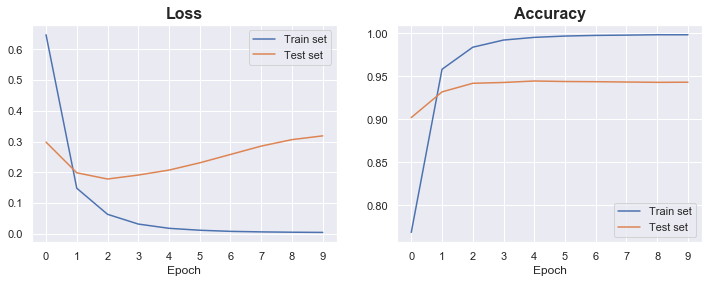

In [318]:
epochs = 10

model.fit(
    x_train, y_train_onehot, epochs=len(history.train_loss_list) + epochs, batch_size=batch_size, verbose=0,
    validation_data=(x_test, y_test_onehot),
    callbacks=[history], initial_epoch=len(history.train_loss_list)
)

history.print_scores()
history.plot()
plt.show()


# Word2vec (frozen embeddings)

NN architecture is identical to that one from part three.

In [ ]:
import gensim

EMBEDDINGS_FILE = 'file://D://models//ruscorpora_mystem_cbow_300_2_2015.bin.gz'
wv = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDINGS_FILE, binary=True).wv

In [286]:
def word_list_to_index(array):
    idx_list = []
    for word in array:
        try:
            idx = model.wv.vocab[word].index
            idx_list.append(idx)
        except KeyError:
            pass
        
    return idx_list
    
df['words_idx'] = df['words'].apply(word_list_to_index)

In [288]:
MAX_LENGTH = 50      # selected according to word count distribution plot

encoded_docs = df['words_idx']
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_LENGTH, padding='post')

In [299]:
target = df['rating']

X_train, X_test, y_train, y_test = train_test_split(
    padded_docs, target,  random_state=42, stratify=target,
)

encoder = LabelEncoder()
encoder.fit(y_train)

y_train_onehot = np_utils.to_categorical(encoder.transform(y_train))
y_test_onehot = np_utils.to_categorical(encoder.transform(y_test))

In [301]:
from keras import backend as K; K.clear_session()
tf.reset_default_graph()

vocab_size, max_features = wv.vectors.shape

adam = keras.optimizers.Adam()

model = Sequential()
model.add(Embedding(vocab_size, max_features, input_length=MAX_LENGTH, weights=[wv.vectors], trainable=False))
model.add(Bidirectional(LSTM(10)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer=adam)

history = TrainingHistory(metric='categorical_accuracy', metric_name='Accuracy',
                          report_num_epochs=1)

Epoch 52: loss=0.43877746488845143 categorical_accuracy=0.8298
Epoch 53: loss=0.4200801779992022 categorical_accuracy=0.8377
Epoch 54: loss=0.4340976621866677 categorical_accuracy=0.8321
Epoch 55: loss=0.4104517247402311 categorical_accuracy=0.8407
Epoch 56: loss=0.4170155855653669 categorical_accuracy=0.8373
Epoch 57: loss=0.4078198111754744 categorical_accuracy=0.8432
Epoch 58: loss=0.4153985688730957 categorical_accuracy=0.8392
Epoch 59: loss=0.4065449260175045 categorical_accuracy=0.8431
Epoch 60: loss=0.3993255810234173 categorical_accuracy=0.8445
Epoch 61: loss=0.3883811413157857 categorical_accuracy=0.8490
Epoch 62: loss=0.40282627164638796 categorical_accuracy=0.8448
Epoch 63: loss=0.41010456351319186 categorical_accuracy=0.8429
Epoch 64: loss=0.3820596097872957 categorical_accuracy=0.8514
Epoch 65: loss=0.3923128347566959 categorical_accuracy=0.8514
Epoch 66: loss=0.3806380522960001 categorical_accuracy=0.8537
Epoch 67: loss=0.38904450761059806 categorical_accuracy=0.8482
Epoc

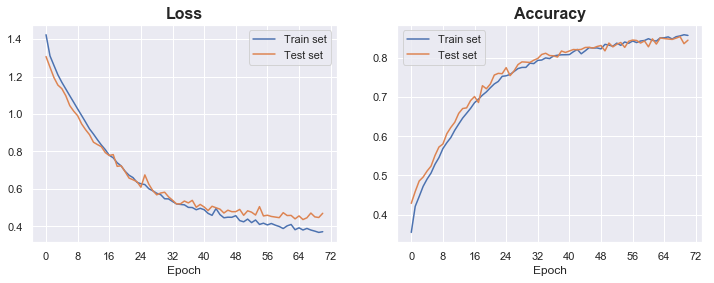

In [306]:
model.fit(
    X_train, y_train_onehot, epochs=len(history.train_loss_list) + 20, batch_size=batch_size, verbose=0,
    validation_data=(X_test, y_test_onehot),
    callbacks=[history], initial_epoch=len(history.train_loss_list)
)

history.print_scores()
history.plot()
plt.show()

# Conclusion

Fasttext with randomly-initialized embeddings:
- Best model, **highest accuracy on the test set** (but the metrics stale quite quickly during training)
- Severe overfitting that is hard to manage. Train set accuracy is unreliable.

RNN with trainable randomly-initialized embeddings:
- Test set accuracy very close to that one of FastText (but chances are it can be improved even more).
- Moderate overfitting

RNN with frozen Word2vec embeddings:
- Freezing embeddings is the worst thing to do here (probably due because of specifics of the corpus). Worst accuracy of three, yet the numbers are comparable and there's some chance for improvement when using more complicated network.
- Very fast to train (small number of trainable parameters)
- Almost no overfitting.